In [1]:
from copy import deepcopy, copy
import os
import pathlib
from random import shuffle

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ChainDataset, ConcatDataset
from livelossplot import PlotLosses

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

In [3]:
class MirexNet(nn.Module):
    def __init__(self):
        super(MirexNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.conv5 = torch.nn.Conv2d(32, 64, 3)
        self.conv6 = torch.nn.Conv2d(64, 64, 3)
        self.conv7 = torch.nn.Conv2d(64, 128, kernel_size=(12, 9))
        self.conv8 = torch.nn.Conv2d(128, 25, 1)
        self.dropout = nn.Dropout(0.5)
        self.avg_pool = nn.AvgPool2d(kernel_size=(13, 3))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv7(x))
        x = self.dropout(x)
        x = self.conv8(x)
        x = self.avg_pool(x)
        return x

In [2]:
from dataset import MirexDataset, MirexFameDataset, MirexChainDataset


beatles_dataset = MirexFameDataset(audio_dir='data/beatles/mp3s-32k/',
                                   ann_dir='data/beatles/chordlabs/',
                                   window_size=8192, hop_length=4096, context_size=7)
queen_dataset = MirexFameDataset(audio_dir='data/queen/mp3/',
                                 ann_dir='data/queen/chordlabs/',
                                 window_size=8192, hop_length=4096, context_size=7)
dataset = ConcatDataset([beatles_dataset, queen_dataset])
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

loader_train = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=32)
loader_val = DataLoader(test_dataset, shuffle=True, num_workers=0, batch_size=32)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

In [3]:
def train_model(model, optimizer, dataloaders, device, epochs=1):
    liveloss = PlotLosses()
    model = model.to(device=device)
    
    for e in range(epochs):
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # put model to training mode
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device=device, dtype=torch.float32)
                labels = labels.to(device=device, dtype=torch.long)
                if phase == 'train':
                    # Zero out all of the gradients for the variables which the optimizer
                    # will update.
                    optimizer.zero_grad()
            
                scores = model(inputs)
                scores = scores.squeeze(3).squeeze(2)                
                loss = F.cross_entropy(scores, labels)
                
                _, preds = torch.max(scores, 1)
                running_corrects += torch.sum(preds == labels)

        
                if phase == 'train':        
                    # This is the backwards pass: compute the gradient of the loss with
                    # respect to each  parameter of the model.
                    loss.backward()
        
                    # Actually update the parameters of the model using the gradients
                    # computed by the backwards pass.
                    optimizer.step()
            
                running_loss += loss.detach() * inputs.size(0)
        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
            
            logs[prefix + ' log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [4]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1, 32, 3, padding=1)),
    ('relu1', nn.ReLU()),
    ('bnorm1', nn.BatchNorm2d(32)),
    ('conv2', nn.Conv2d(32, 32, 3, padding=1)),
    ('relu2', nn.ReLU()),
    ('bnorm2', nn.BatchNorm2d(32)),
    ('conv3', nn.Conv2d(32, 32, 3, padding=1)),
    ('relu3', nn.ReLU()),
    ('bnorm3', nn.BatchNorm2d(32)),
    ('conv4', nn.Conv2d(32, 32, 3, padding=1)),
    ('relu4', nn.ReLU()),
    ('bnorm4', nn.BatchNorm2d(32)),
    ('pool1', nn.MaxPool2d(kernel_size=(2, 1))),
    ('dropout1', nn.Dropout(0.5)),
    ('conv5', nn.Conv2d(32, 64, 3)),
    ('relu5', nn.ReLU()),
    ('bnorm5', nn.BatchNorm2d(64)),
    ('conv6', nn.Conv2d(64, 64, 3)),
    ('relu6', nn.ReLU()),
    ('bnorm6', nn.BatchNorm2d(64)),
    ('pool2', nn.MaxPool2d(kernel_size=(2, 1))),
    ('dropout2', nn.Dropout(0.5)),
    ('conv7', torch.nn.Conv2d(64, 128, kernel_size=(12, 9))),
    ('relu7', nn.ReLU()),
    ('bnorm7', nn.BatchNorm2d(128)),
    ('dropout3', nn.Dropout(0.5)),
    ('conv8', torch.nn.Conv2d(128, 25, 1)),
    ('pool3', nn.AvgPool2d(kernel_size=(13, 3))),
]))

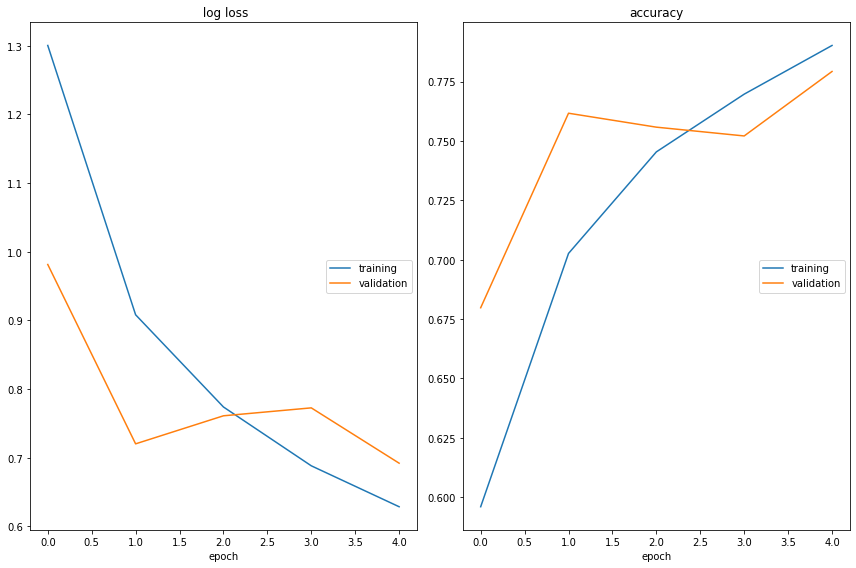

 log loss
	training         	 (min:    0.629, max:    1.301, cur:    0.629)
	validation       	 (min:    0.692, max:    0.982, cur:    0.692)
accuracy
	training         	 (min:    0.596, max:    0.790, cur:    0.790)
	validation       	 (min:    0.680, max:    0.779, cur:    0.779)


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#model = MirexNet()
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-7)

train_model(model, optimizer, dataloaders, device, 5)

In [6]:
torch.save(model.state_dict(), 'models/isio_mirex_cnn.model')
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load('models/mirex_cnn.model'))
# model.eval()

In [12]:
chord_dataset = MirexDataset(audio_dir='data/carole_king/mp3/',
                             ann_dir='data/carole_king/chordlabs/',
                             window_size=8192, hop_length=4096)
loader_chord = DataLoader(chord_dataset, batch_size=None, num_workers=0)

In [9]:
from container import ContextContainer
from metrics import compute_eval_measures

@torch.no_grad()
def estimate_chords(dataloader, model, device, scores_dir='scores'):
    model.eval()  # set model to evaluation mode
    
    if not os.path.exists(scores_dir):
        os.makedirs(scores_dir)
    
    criterion = nn.Softmax()
    for sample in dataloader:
        chromagram = sample['chromagram']
        
        container = ContextContainer(chromagram, 7)
        result = torch.empty(25, chromagram.shape[1])
        for idx, frame in enumerate(container):
            frame = frame.view(1, 1, *frame.shape)
            
            inputs = frame.to(device=device, dtype=torch.float32)
            scores = model(inputs)
            scores = torch.squeeze(scores)
            scores = criterion(scores)

            result[:, idx] = scores
        
        _, preds = torch.max(result, 0)
        result = F.one_hot(preds, result.shape[0]).t_()

        ann_matrix = sample['ann_matrix'].data.numpy()
        result = result.data.numpy()
        
        P, R, F1, TP, FP, FN = compute_eval_measures(ann_matrix, result)
        title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (result.shape[1], TP, FP, FN, P,R,F1)
        print(title)
        #break

In [10]:
estimate_chords(loader_chord, model, device)

Evaluation result (N=2681, TP=1234, FP=1447, FN=464, P=0.460, R=0.727, F=0.564)
Evaluation result (N=2822, TP=1983, FP=839, FN=263, P=0.703, R=0.883, F=0.783)
Evaluation result (N=3198, TP=1031, FP=2167, FN=461, P=0.322, R=0.691, F=0.440)
Evaluation result (N=2786, TP=2263, FP=523, FN=428, P=0.812, R=0.841, F=0.826)
Evaluation result (N=2370, TP=1343, FP=1027, FN=71, P=0.567, R=0.950, F=0.710)
Evaluation result (N=2600, TP=1582, FP=1018, FN=298, P=0.608, R=0.841, F=0.706)


In [4]:
# Add validation accuracy to graph
# Add saving model on best accuracy
# Use argmax instead of max in loss
# Make map-style dataset
# Put optimizer.zero_grad into correct place

In [13]:
estimate_chords(loader_chord, model, device)

Evaluation result (N=3335, TP=613, FP=2722, FN=1234, P=0.184, R=0.332, F=0.237)
Evaluation result (N=2515, TP=29, FP=2486, FN=3, P=0.012, R=0.906, F=0.023)
Evaluation result (N=1928, TP=32, FP=1896, FN=16, P=0.017, R=0.667, F=0.032)
Evaluation result (N=2021, TP=433, FP=1588, FN=224, P=0.214, R=0.659, F=0.323)
Evaluation result (N=1605, TP=668, FP=937, FN=118, P=0.416, R=0.850, F=0.559)
Evaluation result (N=2537, TP=108, FP=2429, FN=47, P=0.043, R=0.697, F=0.080)
Evaluation result (N=3062, TP=262, FP=2800, FN=1010, P=0.086, R=0.206, F=0.121)
